step 1 run roscore to prevent losing of training data

step 2 roslaunch turtlebot3_gazebo turtlebot3_simple.launch

In [1]:
import rospy as ros
import os
from sensor_msgs.msg import LaserScan
import numpy as np
from numpy import Inf
from geometry_msgs.msg import Twist, Pose
from nav_msgs.msg import Odometry
from std_srvs.srv import Empty
from gazebo_msgs.srv import SpawnModel
import random
from math import atan2, pi
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
import rospy as ros
from sensor_msgs.msg import LaserScan
import numpy as np
from numpy import Inf
from geometry_msgs.msg import Twist
from nav_msgs.msg  import Odometry
from std_srvs.srv import Empty
import random
from math import pi
import time
import math

In [4]:
# global hyperparamter how many areas full cricle divided
θres = 4
# global hyperparamter how times publisher publisehs
hz = 5

In [135]:
class GridE:
    
    # the goals default values are set just in front of the robot for testing, 
    # change according to the brief and as you see fit
    def __init__(self, xdim=4, ydim=4, hz=5,  
                 
                 xgoal1min=1.6, xgoal1max=2.2,
                 ygoal1min=1.2, ygoal1max=1.7,
                 quadrant = 3,
                 x= -0.000021, y = -0.000021, θ=0,
                 speed=0.46, θspeed=0.14,
                 resol=0.3, θresol=2*pi/θres,
                 range_min=0.30,
                 rewards=[100, -10, 0, -1,],
                 
                 visual=False):
        
        ros.init_node('RoboEnv2')
        ros.loginfo('Robot Environment node has been created')
        
        self.sub_scan = ros.Subscriber('/scan', LaserScan, self.scan, queue_size=None)
        self.sub_odom = ros.Subscriber('/odom', Odometry, self.odom, queue_size=1)
        self.pub_robot = ros.Publisher('/cmd_vel', Twist, queue_size=1)
        
        self.Vstar = None # for compatibility
        
        #visual
        self.visual = visual
        
        # coordinates of the goal must be changed to match the given environment
        self.xgoal1min = xgoal1min
        self.xgoal1max = xgoal1max
        
        self.ygoal1min = ygoal1min
        self.ygoal1max = ygoal1max
        
        #size of env         
        self.xdim = xdim
        self.ydim = ydim
        
                 
        # $ rostopic hz /scan, rostopic hz /odom
        self.hz = hz  # frequency of scan
        self.rate = ros.Rate(self.hz)
        
        self.speed = speed    # linear speed, change as you see fit
        self.θspeed = θspeed # angular speed, change as you see fi
        
        self.resol = round(resol,2)
        self.θresol = round(θresol,2)
        
        self.cols = int(self.xdim//self.resol) 
        self.rows = int(self.ydim//self.resol)
        self.orts = int(2*pi//self.θresol)    
        
        self.x = x
        self.y = y
        self.θ = θ
    
        self.nC = self.rows*self.cols           # Grid size
        self.nS = self.rows*self.cols*self.orts # State space size
        self.nA = 3
        
        self.range_max = 3.5
        self.range_min = 0.3  # change as you see fit
        
        print('Grid  size = ', self.rows,'x', self.cols,'=', self.nC)
        print('State size = ', self.rows,'x', self.cols, 'x', self.orts,'=',self.nS)
        
        self.robot = Twist()
        self.crashes = []
        self.crash = 0;
        
        self.pos = 'down'

    # change as you see fit
    def scan(self, scans):
        scans = np.array(scans.ranges)
        scans[scans==Inf] = self.range_max
        self.scans = scans

    # change the reward to produce a suitable policy
    def reward(self):
        reward = -10
        done = False
        
        if self.xgoal1max >= self.x >= self.xgoal1min and self.ygoal1max >= self.y >= self.ygoal1min: 
            reward =  100
            done = True
            self.crashes.append(self.crash) 
            self.crash = 0
            
        if self.scans[:3].min() < self.range_min or self.scans[-3:].min() < self.range_min:
            reward =  -10000 
            self.crash +=1
            done = True
#             self.reset()
           
            
        return reward, done
    
    # change as you see fit
    def odom(self, odoms):
        self.x = round(odoms.pose.pose.position.x, 1)   
        self.y = round(odoms.pose.pose.position.y, 1) 
        
        self.z = round(odoms.pose.pose.orientation.z, 3)
        self.w = round(odoms.pose.pose.orientation.w, 3)
        self.current_yaw = math.atan2(2 * (self.w * self.z), 1 - 2 * (self.z**2))

        self.rate.sleep() 
    
    # change this to generate a suitable state representation
    def s_(self):
        x_index = int((self.x + self.xdim/2) // self.resol)
        y_index = int((self.y + self.ydim/2) // self.resol)
        θ_index = int((self.θ + 2 * pi) % (2 * pi) // self.θresol)
        
        state = x_index + y_index * self.cols + θ_index * self.cols * self.rows
        return state
    
    def reset(self):
#        reset_world service
        try:    ros.ServiceProxy('/gazebo/reset_world', Empty).call()
        except: print('could not reset world')
        self.rate.sleep()
        self.pos = 'down'
        return self.s_()

    def step(self, a):
        
        # commented out for testing
        if a==0: self.left()
        if a==1: self.forward()
        if a==2: self.right()
            
        self.s = self.s_() # get the stat
        self.r, self.done = self.reward()
        return self.s, self.r, self.done, {}
    
    def nodeslist(self):
        nodes = os.popen('rosnode list').readlines()
        for i in range(len(nodes)):
            nodes[i] = nodes[i].replace('\n', '')
            print(nodes[i])
    
    # for compatibility, no need to change
    def render(self, **kw):
        pass
    
    def left(self):
        self.pos = self.nextPos(self.pos,'left')
        self.rotate(self.pos)

    def forward(self):
        self.robot.linear.x  = self.speed
        self.robot.angular.z =  0
        self.pub_robot.publish(self.robot)
        time.sleep(5)
        self.rate.sleep()
        self.stop()
    def right(self):
        self.pos = self.nextPos(self.pos,'right')
        self.rotate(self.pos)
    def stop(self):
        self.robot.linear.x = 0
        self.robot.angular.z = 0
        self.pub_robot.publish(self.robot)
        self.rate.sleep()
        
    def nextPos(self, pos, turn):
        if(turn == 'left'):
            if(pos == 'up'):
                return 'right'
            elif(pos == 'right'):
                 return 'down'
            elif(pos == 'down'):
                 return 'left'
            else:
                 return 'up'
        else:
            if(pos == 'up'):
                return 'left'
            elif(pos == 'left'):
                 return 'down'
            elif(pos == 'down'):
                 return 'right'
            else:
                 return 'up'    
        
    def normalize_angle(self, angle):
        while angle > math.pi:
            angle -= 2 * math.pi
        while angle < -math.pi:
            angle += 2 * math.pi
        return angle

    def rotate(self, turn):
        if turn == 'down':
            target_yaw = 0
        elif turn == 'left':
            target_yaw = math.radians(90)
        elif turn == 'up':
            target_yaw = math.radians(180)
        elif turn == 'right':
            target_yaw = math.radians(270)
        else:
            raise ValueError('Invalid direction, must be "down", "left", "up", or "right".')

        angle_tolerance = 0.02  # Adjust this value based on the required precision
        angular_velocity = self.θspeed # rad/s, set this to the desired angular velocity

        target_yaw = self.normalize_angle(target_yaw)
        current_yaw_normalized = self.normalize_angle(self.current_yaw)

        while abs(current_yaw_normalized - target_yaw) > angle_tolerance:
            clockwise_angle_diff = (current_yaw_normalized - target_yaw) % (2 * math.pi)
            counterclockwise_angle_diff = (target_yaw - current_yaw_normalized) % (2 * math.pi)

            if clockwise_angle_diff < counterclockwise_angle_diff:
                self.robot.angular.z = -angular_velocity  # Rotate clockwise
            else:
                self.robot.angular.z = angular_velocity  # Rotate counterclockwise
            
            self.pub_robot.publish(self.robot)
            self.rate.sleep()
            current_yaw_normalized = self.normalize_angle(self.current_yaw)

        self.robot.angular.z = 0  # Stop rotating
        self.pub_robot.publish(self.robot)
        self.rate.sleep()

In [136]:
gride = GridE(xdim=4, ydim=4,
                          xgoal1min=1.0,xgoal1max=1.6,
                          ygoal1min=-1, ygoal1max=1,
                          speed=0.22, θspeed=0.3, hz=hz,
                          resol=1, θresol=(2*pi/θres),
                          range_min=0.38)

[INFO] [1682858474.905618, 8.680000]: Robot Environment node has been created
Grid  size =  4 x 4 = 16
State size =  4 x 4 x 4 = 64


In [116]:
def straight(env):
    env.visual = True
    env.reset()
    done = False
    done = env.step(1)[2]


straight(gride)

In [125]:
# gride.rotate('right')
# gride.rotate('right')
# gride.rotate('right')
# gride.rotate('right')

gride.right()
# gride.current_yaw

In [126]:
gride.reset()

10

In [137]:
import nbimporter
from Lesson5_TemporalDifferenceMethods import *

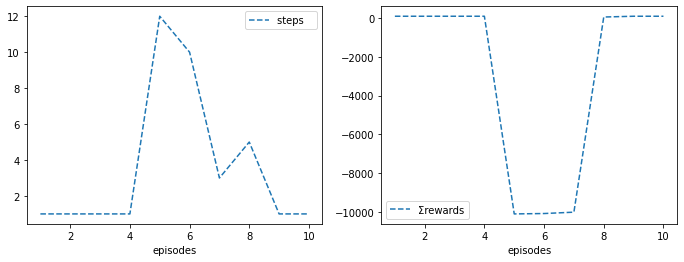

In [138]:
sarsa = Sarsa(env=gride,ε=0.1, α=0.3, episodes=10, seed=10, **demoGame()).interact()
gride.stop()

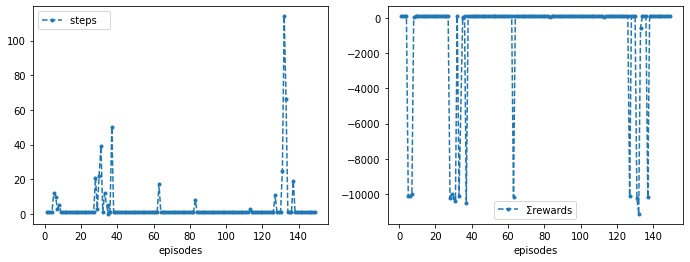

In [ ]:
sarsa.episodes = 200
%time sarsa.interact(resume=True)
gride.stop()